# Financial Fraud Detection Using Scikit-learn

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, loguniform

In [6]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: Synthetic_Financial_datasets_log.csv  


In [7]:
df = pd.read_csv("Synthetic_Financial_datasets_log.csv")

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
correlation = df[['isFraud', 'isFlaggedFraud']].corr()
print(correlation)

                 isFraud  isFlaggedFraud
isFraud         1.000000        0.044109
isFlaggedFraud  0.044109        1.000000


In [12]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [13]:
duplicated_rows = df[df.duplicated()]

num_duplicates = df.duplicated().sum()
print(f"# Duplicated rows: {num_duplicates}")

print(duplicated_rows)

# Duplicated rows: 0
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


In [14]:
# Class balance
print(df['isFraud'].value_counts(normalize=True))

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


## Cleaning Dataset

In [15]:
X = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud', 'isFraud'], axis=1)

In [16]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [17]:
y = df['isFraud']
y

,isFraud
0,0
1,0
2,1
3,1
4,0
...,...
6362615,1
6362616,1
6362617,1
6362618,1


In [18]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0] / df.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0] / df.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0] / df.shape[0]}")

Tamaño del conjunto de entrenamiento: 0.8
Tamaño del conjunto de validación: 0.1
Tamaño del conjunto de prueba: 0.1


In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5090096 entries, 6271196 to 1692743
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 310.7+ MB


In [21]:
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest'],
      dtype='object')

In [22]:
encoder = OneHotEncoder(sparse_output=False)
X_train_cat = pd.DataFrame(encoder.fit_transform(X_train[["type"]]), columns=encoder.get_feature_names_out(["type"]))
X_val_cat = pd.DataFrame(encoder.transform(X_val[["type"]]), columns=encoder.get_feature_names_out(["type"]))
X_test_cat = pd.DataFrame(encoder.transform(X_test[["type"]]), columns=encoder.get_feature_names_out(["type"]))

# 2. MinMaxScaler para columnas numéricas
scaler = MinMaxScaler()
X_train_num = pd.DataFrame(scaler.fit_transform(X_train[numeric_columns]), columns=numeric_columns)
X_val_num = pd.DataFrame(scaler.transform(X_val[numeric_columns]), columns=numeric_columns)
X_test_num = pd.DataFrame(scaler.transform(X_test[numeric_columns]), columns=numeric_columns)

# Concatenar las columnas transformadas
X_train_transformed = pd.concat([X_train_num, X_train_cat], axis=1)
X_val_transformed = pd.concat([X_val_num, X_val_cat], axis=1)
X_test_transformed = pd.concat([X_test_num, X_test_cat], axis=1)

In [23]:
X_train_transformed

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0.832884,0.004180,0.078368,0.101965,0.001421,0.000336,1.0,0.0,0.0,0.0,0.0
1,0.219677,0.002298,0.003938,0.009017,0.002264,0.001667,1.0,0.0,0.0,0.0,0.0
2,0.513477,0.000216,0.000061,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
3,0.241240,0.005707,0.003025,0.000000,0.000259,0.001740,0.0,1.0,0.0,0.0,0.0
4,0.047170,0.002229,0.000000,0.000000,0.005987,0.006563,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5090091,0.207547,0.001403,0.084824,0.104547,0.000693,0.000328,1.0,0.0,0.0,0.0,0.0
5090092,0.249326,0.000027,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0
5090093,0.470350,0.000114,0.000995,0.000982,0.000907,0.000936,0.0,1.0,0.0,0.0,0.0
5090094,0.412399,0.000790,0.000341,0.000000,0.000719,0.000924,0.0,1.0,0.0,0.0,0.0


In [24]:
X_train.iloc[5090091]

,1570006
step,155
type,CASH_IN
amount,129715.85
oldbalanceOrg,5054252.83
newbalanceOrig,5183968.68
oldbalanceDest,246692.94
newbalanceDest,116977.09


## Logistic Regression

In [25]:
model_lr = LogisticRegression(random_state=42)

cv_scores = cross_val_score(model_lr, X_train_transformed, y_train, cv=5, scoring="accuracy")

print("Cross-validation accuracy scores:", cv_scores)
print(f"Mean accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.99870435 0.99870533 0.99870533 0.99870435 0.99870435]
Mean accuracy: 0.9987


In [29]:
param_dist = {
    'C': loguniform(1e-4, 1e+2),
    'solver': ['liblinear', 'saga'],  # Ejemplo de posibles valores para un modelo
    'max_iter': [100, 200]
}


In [34]:
randomized_search = RandomizedSearchCV(estimator=model_lr, param_distributions=param_dist, n_iter=5, cv=3, random_state=42, n_jobs=-1, verbose=True)

randomized_search.fit(X_train_transformed, y_train)
print(randomized_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 608.0332116863506, 'max_iter': 100, 'solver': 'liblinear'}


In [35]:
best_model = randomized_search.best_estimator_
y_val_pred = best_model.predict(X_val_transformed)


Classification Report for Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635434
           1       0.90      0.43      0.58       828

    accuracy                           1.00    636262
   macro avg       0.95      0.71      0.79    636262
weighted avg       1.00      1.00      1.00    636262


Classification Report for Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635470
           1       0.89      0.40      0.55       792

    accuracy                           1.00    636262
   macro avg       0.94      0.70      0.77    636262
weighted avg       1.00      1.00      1.00    636262



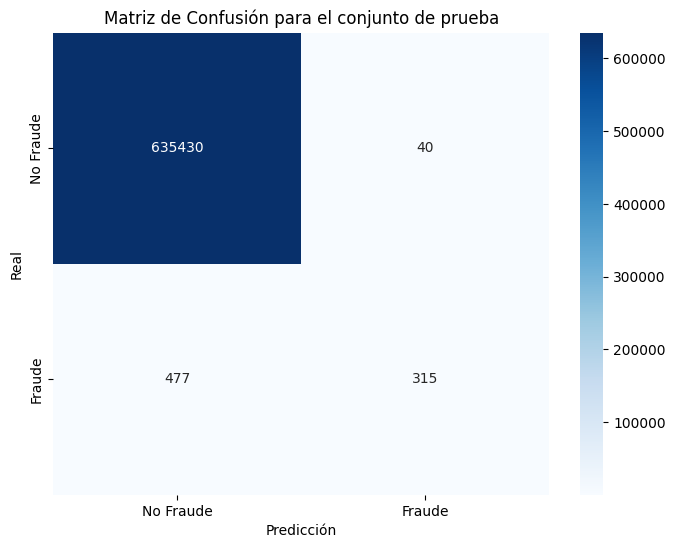

In [36]:
print("\nClassification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

y_test_pred = best_model.predict(X_test_transformed)

print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fraude', 'Fraude'], yticklabels=['No Fraude', 'Fraude'])
plt.title("Matriz de Confusión para el conjunto de prueba")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

TODO: Fix class disbalance